In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [10]:
############################################################
### open the file and read in coordinate data
############################################################

## Some constants
nyr = 10
# grid area in m2
grid_area = 145331722217.843

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in_nohrv = 'run1_1x1brazil.elm.h0.2001_2010.hrv_uniform.nc'
# filename_in_wthrv = 'run1_1x1brazil.elm.h0.1951_2000.cbased_hrv.nc'
# One boreal site
filename_in_wthrv = 'run1_1x1brazil.elm.h0.2001_2010.hrv_spike.nc'

fin_nohrv = nc.netcdf_file(filename_in_nohrv)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin_nohrv.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin_nohrv.variables['fates_levage'][:]
cohort_size_bins = fin_nohrv.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
#sec_frac_nohrv = fin_nohrv.variables['SECONDARY_FOREST_FRACTION'][:]
area_age_nohrv = fin_nohrv.variables['PATCH_AREA_BY_AGE'][:]
#hrv_c_nohrv = fin_nohrv.variables['WOOD_PRODUCT'][:]
hrv_flux10c_nohrv_elm = fin_nohrv.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_nohrv_elm = fin_nohrv.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
hrv_10c_nohrv = fin_nohrv.variables['PROD10C'][:]
hrv_100c_nohrv = fin_nohrv.variables['PROD100C'][:]
fin_nohrv.close()

fin_wthrv = nc.netcdf_file(filename_in_wthrv)
## read in variables
biomass_wthrv = fin_wthrv.variables['BIOMASS_BY_AGE'][:]
#sec_frac_wthrv = fin_wthrv.variables['SECONDARY_FOREST_FRACTION'][:]
area_age_wthrv = fin_wthrv.variables['PATCH_AREA_BY_AGE'][:]
#hrv_c_wthrv = fin_wthrv.variables['WOOD_PRODUCT'][:]
hrv_flux10c_wthrv_elm = fin_wthrv.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_wthrv_elm = fin_wthrv.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
hrv_10c_wthrv = fin_wthrv.variables['PROD10C'][:]
hrv_100c_wthrv = fin_wthrv.variables['PROD100C'][:]
fin_wthrv.close()

## Open land use time series
# filename_in_luinput = 'landuse.timeseries_1x1_brazil_hist_simyr1850-2015_c200310_biomass_harvest.nc' 
# One boreal site
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015.testluc_biomass_harvest_last16.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
lu_hrv_frac = fin_luinput.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_c = fin_luinput.variables['HARVEST_VH1'][:]+fin_luinput.variables['HARVEST_VH2'][:]
fin_luinput.close()

# biomass_den = np.nanmean(biomass_wthrv, 1)
biomass_den = np.nansum(biomass_wthrv*area_age_wthrv, 1)
# ## because the bin edges read in define the lower edges, add a last index to each to
# ## represent the upper edge of the distribution (even though there isn't one, really)
# patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
# cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)

Text(0.5,1,'Validate reading LUC fraction')

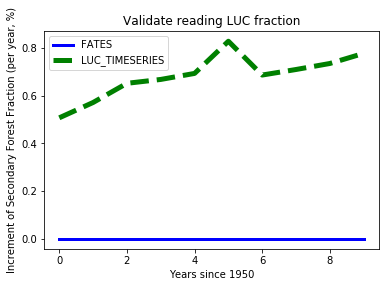

In [3]:
## Validate harvested area.
hrv_area_fates_day = sec_frac_wthrv[1:len(sec_frac_wthrv)]
hrv_area_fates_yr = np.zeros([10])
for iyr in np.arange(0,nyr):
    id_beg = iyr*365
    id_end = (iyr+1)*365-1
    hrv_area_fates_yr[iyr] = hrv_area_fates_day[id_end] - hrv_area_fates_day[id_beg]
hrv_area_lu_yr = lu_hrv_frac[0:10,0,0]

plt.plot(hrv_area_fates_yr*100, 'b-', linewidth=3)
plt.plot(hrv_area_lu_yr*100, 'g--', linewidth=5)
plt.xlabel('Years since 1950')
plt.ylabel('Increment of Secondary Forest Fraction (per year, %)')
plt.legend(['FATES', 'LUC_TIMESERIES'])
plt.title('Validate reading LUC fraction')
# plt.savefig('validate_cbased_luc_frac.png')

In [ ]:
## Validate harvested C (kgC m-2 yr-1). Abandon the last year.
hrv_c_fates_day = hrv_c_wthrv[1:len(hrv_c_wthrv)]
hrv_c_fates_yr = np.zeros([9])
for iyr in np.arange(0,nyr-1):
    id_beg = iyr*365
    id_end = (iyr+1)*365-1
    hrv_c_fates_yr[iyr] = np.sum(hrv_c_fates_day[id_beg:id_end])*grid_area
# Since the harvest happen after day 30, there's a shift we need to account for
hrv_c_elm_day = hrv_flux10c_wthrv_elm[1:len(hrv_flux10c_wthrv_elm)]+hrv_flux100c_wthrv_elm[1:len(hrv_flux100c_wthrv_elm)]
hrv_c_elm_yr = np.zeros([9])
for iyr in np.arange(0,nyr-1):
    id_beg = iyr*365+30
    id_end = (iyr+1)*365-29
    hrv_c_elm_yr[iyr] = np.mean(hrv_c_elm_day[id_beg:id_end])*3600*24*365/1000.

hrv_c_luh2_yr = lu_hrv_c[2:9,0,0]
    
plt.plot(hrv_c_fates_yr, 'b-', linewidth=3)
plt.plot(hrv_c_luh2_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1950')
plt.ylabel('Harvested C (kgC m-2 yr-1)')
plt.legend(['FATES', 'LUH2'])
plt.title('Validate reading harvested C from Data')
# plt.savefig('validate_cbased_hrv_c.png')


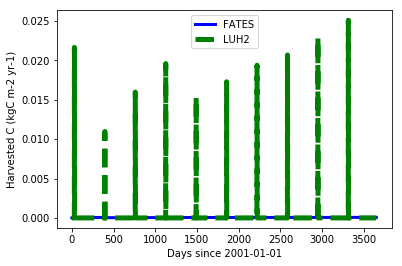

In [9]:
hrv_pool_nohrv = hrv_flux10c_nohrv_elm + hrv_flux100c_nohrv_elm
hrv_pool_wthrv = hrv_flux10c_wthrv_elm + hrv_flux100c_wthrv_elm
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C (gC m-2)')
plt.legend(['Spike', 'Uniform'])


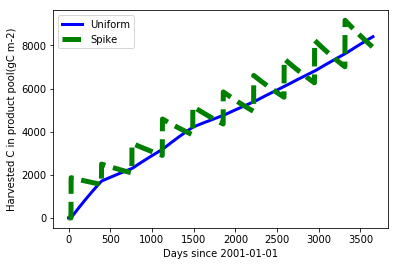

In [13]:
hrv_c_nohrv = hrv_10c_nohrv + hrv_100c_nohrv
hrv_c_wthrv = hrv_10c_wthrv + hrv_100c_wthrv
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C in product pool(gC m-2)')
plt.legend(['Uniform', 'Spike'])
plt.savefig('comparison_uniform_vs_spike.png')

Text(0.5,1,'Check total biomass')

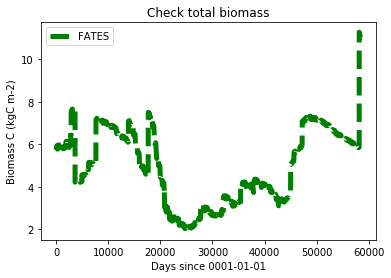

In [13]:
# Check total biomass
plt.plot(biomass_den, 'g--', linewidth=5)
plt.xlabel('Days since 0001-01-01')
plt.ylabel('Biomass C (kgC m-2)')
plt.legend(['FATES'])
plt.title('Check total biomass')

